# Kaggle: COVID Tweet Sentiment Classification

This is a solution for Kaggle project: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

Twitter is a place to express thoughts and ideas and spread news and information, thus makes it a great source to track trends worldwide. Through the collected tweets, we can evaluate people's attitude toward Covid and pandemic through the trending keywords and tags through time. The estimator can be useful for identifying inappropriate tweets and stop toxic propaganda or evaluating strategies to promote social distancing using trend words.

The task is to classify tweet sentiments in given tweets.

This notebook approach this NLP task using TensorFlow LSTM and GRU algorithms.

Data has following columns:

|Column |Notes |
|:------|:-------|
UserName | User ID
ScreenName| User display name
Location | User location
TweetAt | Date
OriginalTweet | Tweet content
Sentiment | Extremely negative, Negative, Neutral, Positive, Extremely positive

## 1. Load modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from helperFuns import *

pd.options.display.max_colwidth = 100

## 2. Load data

In [2]:
train_df = pd.read_csv("Corona_NLP_train.csv", header=0, encoding='latin1')
test_df = pd.read_csv("Corona_NLP_test.csv", header=0, encoding='latin1')

In [3]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone n...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-...",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL B...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid...",Extremely Negative


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-...",Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack...",Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News ...,Neutral


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


## 3. Basic cleaning

Both UserName and ScreenName identify a user. We don't need both.

In [7]:
print(len(set(train_df.ScreenName)) == len(set(train_df.UserName)))
print(len(set(test_df.ScreenName)) == len(set(test_df.UserName)))

True
True


In [8]:
train_df.drop(columns="ScreenName", inplace=True)
test_df.drop(columns="ScreenName", inplace=True)
train_df.set_index("UserName", inplace=True)
test_df.set_index("UserName", inplace=True)

Location has some NULL cells, fill with "N/A"

In [9]:
train_df.Location.fillna("N/A", inplace=True)
test_df.Location.fillna("N/A", inplace=True)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 3799 to 44955
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       41157 non-null  object
 1   TweetAt        41157 non-null  object
 2   OriginalTweet  41157 non-null  object
 3   Sentiment      41157 non-null  object
dtypes: object(4)
memory usage: 1.6+ MB


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 1 to 3798
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       3798 non-null   object
 1   TweetAt        3798 non-null   object
 2   OriginalTweet  3798 non-null   object
 3   Sentiment      3798 non-null   object
dtypes: object(4)
memory usage: 148.4+ KB


## 4. EDA
## Encode Sentiment
There are 5 types of sentiment, thus neural network will have 5 class in output layer.

In [12]:
set(train_df.Sentiment)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

<AxesSubplot:>

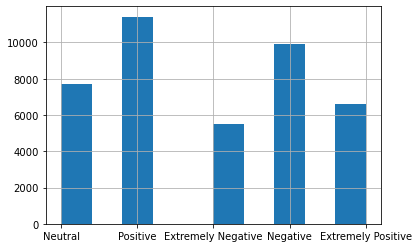

In [13]:
train_df.Sentiment.hist()

## Alternative way to encode Sentiment
After one round of training, one of the observations is that extreme tone isn't very obvious and easily confused with regular tone. Since model isn't sentitive enough to capture the intensity of sentiment, try combining extreme negative with negative and extreme positive with positive to eliminate "noise".

In [14]:
def encode_sentiment(df):
    encoder = {'Extremely Negative': 0,
               'Negative': 0,
               'Neutral': 1,
               'Positive': 2, 
               'Extremely Positive': 2}
    return df.Sentiment.map(encoder)

In [15]:
train_df['Sentiment_encode'] = encode_sentiment(train_df)
test_df['Sentiment_encode'] = encode_sentiment(test_df)

In [16]:
target_len = len(set(train_df.Sentiment_encode))
target_len

3

## Only keep tweet content
After some experiment, location and date are not very corelated to sentiment. Mainly is by text content.

In [17]:
train_df = train_df[['OriginalTweet', 'Sentiment_encode']]
test_df = test_df[['OriginalTweet', 'Sentiment_encode']]

## Keep most mentioned accounts
Discard accounts to eliminate noise but keep the most frequently mentioned accounts.

In [18]:
# Keep most popular tagged accounts:
top_tags = top_N_tags(train_df)
top_tags

['@realDonaldTrump',
 '@Tesco',
 '@sainsburys',
 '@BorisJohnson',
 '@narendramodi',
 '@amazon',
 '@asda',
 '@PMOIndia',
 '@Morrisons',
 '@piersmorgan']

## Keep most popular hashtags
Discard hashtags to eliminate noise and keep only the most popular hashtags.

In [19]:
# Keep most popular hashtags:
top_hashtags = top_N_hashtags(train_df)
top_hashtags

['#toiletpaper',
 '#SocialDistancing',
 '#pandemic',
 '#StayHomeSaveLives',
 '#lockdown',
 '#StayAtHome',
 '#supermarket',
 '#StayHome',
 '#panicbuying',
 '#retail']

## Download and expand NLTK stop words
Remove common words using stopwords in NLTK module.

In [20]:
stop_words = stopwords.words('english')
stop_words += [c for c in string.ascii_lowercase]
stop_words += ["in", "on", "at", "via", "due", "could", "would", "may", "one", "still", 
               "even", "also", "every", "two", "etc", "per"]

ps = PorterStemmer()
# wnl = WordNetLemmatizer()

## 5. Clean text
Define functions to clean text:
1. Remove hyperlinks and addresses
2. Remove @ mentions except most frequently tagged accounts
3. Remove # hashtags except most popular hashtags
4. Remove remaining special characters, numbers, and tab/carriage-return/line-feed.
5. Remove subwords that has non alphabetical characters
6. Remove stop words
7. Stemming
8. Lemmatization

## Clean OriginalTweet
Clean the tweet message and append location to front of the message.

In [21]:
def clean_text(text):
    text = remove_link(text)
    text = remove_tag(text, top_tags)
    text = remove_hashtag(text, top_hashtags)
    text = remove_special_char(text)
    text = remove_non_english(text)
    text = remove_stop_words(text, stop_words)
    text = stemming(text, ps)
#     text = lemmatization(text, wnl)
    return text

def clean_original_tweet(df):
    clean_tweet = []
    for tweet in df.index:
        # clean message
        msg = df.OriginalTweet.loc[tweet].lower()
        clean_tweet.append(clean_text(msg))

    df['CleanTweet'] = clean_tweet

In [22]:
clean_original_tweet(train_df)
clean_original_tweet(test_df)

In [23]:
train_df.head()

,OriginalTweet,Sentiment_encode,CleanTweet
UserName,,,
3799,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://...,1,
3800,advice Talk to your neighbours family to exchange phone numbers create contact list with phone n...,2,advic talk neighbour famili exchang phone number creat contact list phone number neighbour schoo...
3801,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-...",2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3802,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL B...",2,food stock empti pleas panic enough food everyon take need stay calm stay safe
3803,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid...",0,readi go supermarket outbreak paranoid food stock litterali empti seriou thing pleas panic caus ...


In [24]:
test_df.head()

,OriginalTweet,Sentiment_encode,CleanTweet
UserName,,,
1,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-...",0,trend new yorker encount empti supermarket shelv pictur wegman brooklyn sold onlin grocer foodki...
2,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack...",2,find hand sanit fred meyer turn pack purel check concern drive price
3,Find out how you can protect yourself and loved ones from #coronavirus. ?,2,find protect love one
4,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after...,0,buy hit citi anxiou shopper stock food amp medic suppli worker becom st confirm patient stage event
5,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News ...,1,toiletpap week everyon buy babi milk powder next everyon buy toilet paper


## Average tweet length
25-30 characters include most of the context in most tweets.

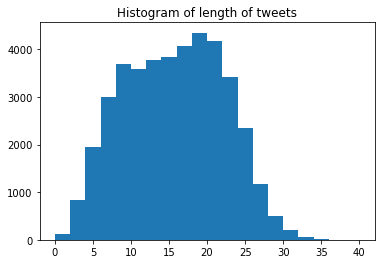

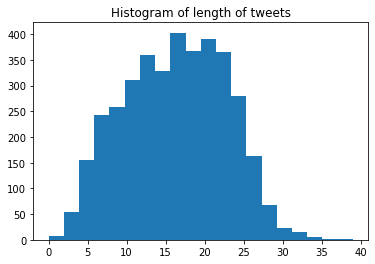

In [25]:
plot_tweet_len(train_df)
plot_tweet_len(test_df)

## Tokenize text

In [26]:
tokenizer = fit_tokenizer(train_df, num_words=10000)
vocab_size = len(tokenizer.word_index)
print("Vocab size:", vocab_size)
max_len = 25

train_corpus = tokenize_text(tokenizer, train_df, max_len)
test_corpus = tokenize_text(tokenizer, test_df, max_len)

Vocab size: 22595


## Most frequent words/tokens

In [27]:
tokens = pd.DataFrame(dict(tokenizer.word_counts).values(), index=dict(tokenizer.word_counts).keys())

# most used N words
N = 15
tokens.sort_values(by=0, ascending=False).iloc[:N]

,0
covid,10661
price,8998
store,8234
supermarket,7828
food,7033
groceri,6531
peopl,5574
amp,5187
consum,5074
shop,4886


## 6. Modeling
### Conv1D

In [28]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, verbose=2)
epoch = 100

In [29]:
embd_dim = 32
batch = 32
conv1d_model_name = "Conv1D_model_alter.h5"

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embd_dim, input_length=max_len),
    tf.keras.layers.Conv1D(embd_dim*4, 3, activation=tf.nn.relu),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(target_len, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(train_corpus, train_df['Sentiment_encode'], validation_split=0.3,
          epochs=epoch, batch_size=batch, callbacks=[earlystopping])
model.save(conv1d_model_name)

Epoch 1/100
901/901 [==============================] - 11s 11ms/step - loss: 0.8410 - accuracy: 0.5981 - val_loss: 0.4826 - val_accuracy: 0.8253
Epoch 2/100
901/901 [==============================] - 8s 9ms/step - loss: 0.4040 - accuracy: 0.8604 - val_loss: 0.4571 - val_accuracy: 0.8320
Epoch 3/100
901/901 [==============================] - 8s 9ms/step - loss: 0.3244 - accuracy: 0.8925 - val_loss: 0.4881 - val_accuracy: 0.8247
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


### Bidirectional LSTM

In [30]:
embd_dim = 32
batch = 32
lstm_model_name = "BiDirLSTM_model_alter.h5"

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embd_dim, input_length=max_len),
    tf.keras.layers.LSTM(embd_dim*2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(target_len, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(train_corpus, train_df['Sentiment_encode'], 
          epochs=epoch, batch_size=batch, 
          validation_split=0.3,
          callbacks=[earlystopping])
model.save(lstm_model_name)

Epoch 1/100
901/901 [==============================] - 16s 15ms/step - loss: 0.9545 - accuracy: 0.4771 - val_loss: 0.8116 - val_accuracy: 0.5867
Epoch 2/100
901/901 [==============================] - 13s 15ms/step - loss: 0.7629 - accuracy: 0.5819 - val_loss: 0.6567 - val_accuracy: 0.7295
Epoch 3/100
901/901 [==============================] - 13s 15ms/step - loss: 0.5434 - accuracy: 0.7895 - val_loss: 0.5035 - val_accuracy: 0.8145
Epoch 4/100
901/901 [==============================] - 13s 15ms/step - loss: 0.3778 - accuracy: 0.8743 - val_loss: 0.5041 - val_accuracy: 0.8175
Epoch 5/100
901/901 [==============================] - 13s 15ms/step - loss: 0.3110 - accuracy: 0.8992 - val_loss: 0.5156 - val_accuracy: 0.8216
Epoch 6/100
901/901 [==============================] - 13s 15ms/step - loss: 0.2650 - accuracy: 0.9155 - val_loss: 0.5695 - val_accuracy: 0.8104
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


### Bidirectional GRU

In [31]:
embd_dim = 32
batch = 32
gru_model_name = 'BiDirGRU_model_alter.h5'

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embd_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(embd_dim*2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(target_len, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(train_corpus, train_df['Sentiment_encode'], 
          epochs=epoch, batch_size=batch, 
          validation_split=0.3,
          callbacks=[earlystopping])
model.save(gru_model_name)

Epoch 1/100
901/901 [==============================] - 20s 18ms/step - loss: 0.9024 - accuracy: 0.5195 - val_loss: 0.4876 - val_accuracy: 0.8195
Epoch 2/100
901/901 [==============================] - 16s 17ms/step - loss: 0.4174 - accuracy: 0.8534 - val_loss: 0.4780 - val_accuracy: 0.8306
Epoch 3/100
901/901 [==============================] - 16s 18ms/step - loss: 0.3322 - accuracy: 0.8881 - val_loss: 0.4991 - val_accuracy: 0.8322
Epoch 4/100
901/901 [==============================] - 16s 17ms/step - loss: 0.2918 - accuracy: 0.9056 - val_loss: 0.5332 - val_accuracy: 0.8250
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


## 7. Evaluate model

In [32]:
model = tf.keras.models.load_model(conv1d_model_name)
evaluate(model, test_corpus, test_df.Sentiment_encode)

119/119 - 0s - loss: 0.5626 - accuracy: 0.8154
[[1356   72  205]
 [  89  451   79]
 [ 203   53 1290]]
              precision    recall  f1-score   support

           0      0.823     0.830     0.827      1633
           1      0.783     0.729     0.755       619
           2      0.820     0.834     0.827      1546

    accuracy                          0.815      3798
   macro avg      0.808     0.798     0.803      3798
weighted avg      0.815     0.815     0.815      3798



In [33]:
model = tf.keras.models.load_model(lstm_model_name)
evaluate(model, test_corpus, test_df.Sentiment_encode)

119/119 - 1s - loss: 0.8129 - accuracy: 0.8167
[[1334   68  231]
 [  83  459   77]
 [ 177   60 1309]]
              precision    recall  f1-score   support

           0      0.837     0.817     0.827      1633
           1      0.782     0.742     0.761       619
           2      0.810     0.847     0.828      1546

    accuracy                          0.817      3798
   macro avg      0.809     0.802     0.805      3798
weighted avg      0.817     0.817     0.816      3798



In [34]:
model = tf.keras.models.load_model(gru_model_name)
evaluate(model, test_corpus, test_df.Sentiment_encode)

119/119 - 1s - loss: 0.8380 - accuracy: 0.8157
[[1360   83  190]
 [  82  479   58]
 [ 225   62 1259]]
              precision    recall  f1-score   support

           0      0.816     0.833     0.824      1633
           1      0.768     0.774     0.771       619
           2      0.835     0.814     0.825      1546

    accuracy                          0.816      3798
   macro avg      0.806     0.807     0.807      3798
weighted avg      0.816     0.816     0.816      3798

